## Notebooks to make the queries to the api of the models to get the response

In [1]:
import pandas as pd
import requests
from typing import Dict
import time
import os
import json
import re
import seaborn as sns
from matplotlib import pyplot as plt

### Reading the data

In [2]:
data = pd.read_csv("../02-dataset/data/cleaned/all_questions_df_english.csv")
data

,Unnamed: 0,description,alternatives,year,subject,ground_truth,index_question,text_concat_english,text_concat_portuguese
0,0,Questão 4) A Minor Bird I have wished a bird w...,"['A) culpa por não poder cuidar do pássaro.', ...",2020,"Linguagens, códigos e suas tecnologias",D,4,Question 4) Minor Bird I Have Wished a Bird Wo...,Questão 4) A Minor Bird I have wished a bird w...
1,1,"Questão 5) Finally, Aisha finished with her cu...","['A) reforçam um padrão de beleza.', 'B) retra...",2020,"Linguagens, códigos e suas tecnologias",C,5,"Question 5) Finally, Aisha Finished with Her C...","Questão 5) Finally, Aisha finished with her cu..."
2,2,Questão 01) Pablo Pueblo Regresa un hombre en ...,['A) contrapor a individualidade de um sujeito...,2020,"Linguagens, códigos e suas tecnologias",A,6,Question 01) Pablo Pueblo returns a Hombre en ...,Questão 01) Pablo Pueblo Regresa un hombre en ...
3,3,"Questão 4) Oye, Pito, ésta es: la vida bruta d...",['A) rejeição da língua utilizada por seus ant...,2020,"Linguagens, códigos e suas tecnologias",E,9,"Question 4) Oye, Pito, Estas Es: La Life of Un...","Questão 4) Oye, Pito, ésta es: la vida bruta d..."
4,4,Questão 5) Poco después apareció en casa de El...,['A) determinação para conduzir discussões pes...,2020,"Linguagens, códigos e suas tecnologias",E,10,Question 5) Poco Después Apareció en House of ...,Questão 5) Poco después apareció en casa de El...
...,...,...,...,...,...,...,...,...,...
1001,1001,QuESTÃO 167) Em um jogo disputado em uma mesa ...,"['A) Arthur, pois a soma que escolheu é a meno...",2011,Matemática e suas tecnologias,C,172,Question 167) In a game played at a pool table...,QuESTÃO 167) Em um jogo disputado em uma mesa ...
1002,1002,QuESTÃO 168) É possível usar água ou comida pa...,"['A) 20 mL.', 'B) 24 mL.', 'C) 100 mL.', 'D) 1...",2011,Matemática e suas tecnologias,C,173,Question 168) It is possible to use water or f...,QuESTÃO 168) É possível usar água ou comida pa...
1003,1003,"QuESTÃO 171) Nos últimos cinco anos, 32 mil mu...","['A) 4 mil.', 'B) 9 mil.', 'C) 21 mil.', 'D) 3...",2011,Matemática e suas tecnologias,D,176,"Question 171) In the last five years, 32,000 w...","QuESTÃO 171) Nos últimos cinco anos, 32 mil mu..."
1004,1004,QuESTÃO 174) O setor de recursos humanos de um...,"['A) 24.', 'B) 31.', 'C) 32.', 'D) 88.', 'E) 8...",2011,Matemática e suas tecnologias,E,179,Question 174) The human resources sector of a ...,QuESTÃO 174) O setor de recursos humanos de um...


## Making the requests

In [3]:
def get_text(line : pd.Series, lang: str, verbose = False):
    """
    """
    if lang == 'pt':
        prompt = \
        f"""Qual é a alternativa correta para a questão que está entre <>? responda só com a letra que representa a alternativa:\n\n<{line['text_concat_portuguese']}>"""
    else:
        prompt = \
        f"""What is the correct alternative to the question between <>? Answer only with the letter that represents the alternative:\n\n<{line['text_concat_english']}>"""

    if verbose:
        print(prompt)
    return prompt

def make_querie(url : str, text : str, temperature: float = None, stop_tokens: str = None):
    """
    """
    params = {}
    params['query'] = text
    if not(temperature is None):
        params['temperature'] = temperature
    if not(stop_tokens is None):
        params['stop_tokens'] = stop_tokens
    start_time = time.time()
    request = requests.get(url, params = params)

    return_infos = {
        'time_to_run': time.time() - start_time,
        'result': eval(request.text)['result']
    }
    
    return return_infos

def make_all_requests(
        df: pd.DataFrame, 
        models: Dict, 
        temperature: float,
        stop_tokens: str,
        path_to_save: str,
        lang: str,
        base_path: str = "http://localhost:8000",
        verbose: bool = True
    ):
    """
    """
    
    try:
        os.mkdir(path_to_save)
    except:
        pass

    for model,url in models.items():
        
        for index,line in df.iterrows():
            name_arq = f"{line['year']}-{line['index_question']}-{model}.json"
            full_path_arq = f"{path_to_save}/{name_arq}"
            
            # if alredy process, not process
            if os.path.exists(full_path_arq):
                continue
            
            # otherwise compute
            url_req = base_path + url
            
            result = make_querie(
                url = url_req,
                text = get_text(line, lang),
                temperature = temperature,
                stop_tokens = stop_tokens
            )
            
            with open(full_path_arq, 'w') as file:
                file.write(json.dumps(result,indent=2,ensure_ascii=False))
            
            if verbose:
                print(f"--> {model} || {index} || {result}")

        print(f"Run the model {model}")
    

In [4]:
models = {
    "llama_7b":"/models/llama/7b",
    "llama_13b":"/models/llama/13b",
    "alpaca_7b": "/models/alpaca/7b",
    "alpaca_13b": "/models/alpaca/13b",
    "koala_7b": "/models/koala/7b",
    "koala_13b": "/models/koala/13b",
    "vicuna_7b": "/models/vicuna/7b",
    "vicuna_13b": "/models/vicuna/13b",
    "llama_2_7b": "/models/llama2/7b/",
    "llama_2_13b": "/models/llama2/13b/",
#     "vicuna1.5_7b": "/models/vicuna1.5/7b/",
#     "vicuna1.5_13b": "/models/vicuna1.5/13b/",
}

### First experiment. Only concatenating the text and seding to the model and collecting the response
- PT BR

In [5]:
PATH_SAVE_DATA = "data/04-prompt-ask"
LANG = 'en'
BASE_PATH = "http://localhost:8000"

make_all_requests(
    df = data,
    models = models,
    temperature = 0.1,
    stop_tokens = "pergunta:,</s>,\n",
    path_to_save = PATH_SAVE_DATA,
    lang = LANG,
    base_path = BASE_PATH
)

Run the model llama_7b
Run the model llama_13b
Run the model alpaca_7b
Run the model alpaca_13b
Run the model koala_7b
Run the model koala_13b
Run the model vicuna_7b
Run the model vicuna_13b
Run the model llama_2_7b
Run the model llama_2_13b


### Reading the data processed

In [6]:
def get_response(
    path_jsons: str,
    dataframe: pd.DataFrame,
    models: Dict
):
    """
    """
    for name, _ in models.items():
        aux = []
        for index,line in dataframe.iterrows():
            name_arq = f"{line['year']}-{line['index_question']}-{name}.json"
            
            with open(f"{path_jsons}/{name_arq}",'r') as file:
                json_response = json.loads(file.read())
            
            aux.append(json_response)
        dataframe[f'{name}_response'] = aux
            
    return dataframe

data_results = get_response(
    path_jsons = PATH_SAVE_DATA,
    dataframe = data.copy(),
    models = models
)

In [7]:
data_results

,Unnamed: 0,description,alternatives,year,subject,ground_truth,index_question,text_concat_english,text_concat_portuguese,llama_7b_response,llama_13b_response,alpaca_7b_response,alpaca_13b_response,koala_7b_response,koala_13b_response,vicuna_7b_response,vicuna_13b_response,llama_2_7b_response,llama_2_13b_response
0,0,Questão 4) A Minor Bird I have wished a bird w...,"['A) culpa por não poder cuidar do pássaro.', ...",2020,"Linguagens, códigos e suas tecnologias",D,4,Question 4) Minor Bird I Have Wished a Bird Wo...,Questão 4) A Minor Bird I have wished a bird w...,"{'time_to_run': 101.63203120231628, 'result': ...","{'time_to_run': 28.645726680755615, 'result': ...","{'time_to_run': 16.789446592330933, 'result': ...","{'time_to_run': 42.55182933807373, 'result': '...","{'time_to_run': 16.491862297058105, 'result': ...","{'time_to_run': 45.333508253097534, 'result': ...","{'time_to_run': 17.66286325454712, 'result': '...","{'time_to_run': 54.068565368652344, 'result': ...","{'time_to_run': 13.932859182357788, 'result': ...","{'time_to_run': 27.529331922531128, 'result': ..."
1,1,"Questão 5) Finally, Aisha finished with her cu...","['A) reforçam um padrão de beleza.', 'B) retra...",2020,"Linguagens, códigos e suas tecnologias",C,5,"Question 5) Finally, Aisha Finished with Her C...","Questão 5) Finally, Aisha finished with her cu...","{'time_to_run': 47.52169752120972, 'result': '...","{'time_to_run': 55.59168601036072, 'result': '...","{'time_to_run': 30.04198455810547, 'result': '...","{'time_to_run': 62.773356676101685, 'result': ...","{'time_to_run': 32.01136541366577, 'result': '...","{'time_to_run': 63.27913308143616, 'result': '...","{'time_to_run': 32.84776711463928, 'result': '...","{'time_to_run': 88.45954751968384, 'result': '...","{'time_to_run': 28.106574535369873, 'result': ...","{'time_to_run': 53.97209644317627, 'result': '..."
2,2,Questão 01) Pablo Pueblo Regresa un hombre en ...,['A) contrapor a individualidade de um sujeito...,2020,"Linguagens, códigos e suas tecnologias",A,6,Question 01) Pablo Pueblo returns a Hombre en ...,Questão 01) Pablo Pueblo Regresa un hombre en ...,"{'time_to_run': 24.95619821548462, 'result': '...","{'time_to_run': 29.1694016456604, 'result': ' A'}","{'time_to_run': 31.142493963241577, 'result': ...","{'time_to_run': 38.85452055931091, 'result': '...","{'time_to_run': 16.808945178985596, 'result': ...","{'time_to_run': 32.15293741226196, 'result': '...","{'time_to_run': 16.573533296585083, 'result': ...","{'time_to_run': 47.047483682632446, 'result': ...","{'time_to_run': 13.620575904846191, 'result': ...","{'time_to_run': 26.190595626831055, 'result': ..."
3,3,"Questão 4) Oye, Pito, ésta es: la vida bruta d...",['A) rejeição da língua utilizada por seus ant...,2020,"Linguagens, códigos e suas tecnologias",E,9,"Question 4) Oye, Pito, Estas Es: La Life of Un...","Questão 4) Oye, Pito, ésta es: la vida bruta d...","{'time_to_run': 25.849817752838135, 'result': ...","{'time_to_run': 30.26042890548706, 'result': '...","{'time_to_run': 17.928412437438965, 'result': ...","{'time_to_run': 36.94541001319885, 'result': '...","{'time_to_run': 17.387615203857422, 'result': ...","{'time_to_run': 37.288063526153564, 'result': ...","{'time_to_run': 18.360440492630005, 'result': ...","{'time_to_run': 51.37808346748352, 'result': '...","{'time_to_run': 15.242230892181396, 'result': ...","{'time_to_run': 29.708338260650635, 'result': ..."
4,4,Questão 5) Poco después apareció en casa de El...,['A) determinação para conduzir discussões pes...,2020,"Linguagens, códigos e suas tecnologias",E,10,Question 5) Poco Después Apareció en House of ...,Questão 5) Poco después apareció en casa de El...,"{'time_to_run': 34.0896692276001, 'result': ' C'}","{'time_to_run': 40.77724814414978, 'result': '...","{'time_to_run': 23.07540225982666, 'result': '...","{'time_to_run': 47.04820513725281, 'result': '...","{'time_to_run': 23.445996522903442, 'result': ...","{'time_to_run': 44.59329581260681, 'result': '...","{'time

## Defining the heuristics to collect the response of the queries

In [8]:
def first_caracter(text: str):
    """
    """
    text = text.strip()
    if len(text) > 1 and text[0].isupper() and not(text[1].isalnum()) and text[0] in 'ABCDE':
        return text[0]
    if len(text) == 1 and text[0] in 'ABCDE':
        return text[0]

    return None

def identify_alternative_mid_text(text: str):
    """
    """
    regex1 = " <?[A-E]>? ?\)? "
    matches1 = re.findall(regex1,text)
    
    regex2 = " <?[A-E]>?\)?"
    matches2 = re.findall(regex2,text)
    
#     matches = matches1 + matches2
    
    if len(matches1) == 1 or len(matches2) == 1:
        options = "ABCDE"
        for o in options:
            if len(matches1) == 1 and o in matches1[0]:
                return o
            elif len(matches2) == 1 and o in matches2[0]:
                return o
    return None



def run_identify_alternative_result(
    dataframe: pd.DataFrame
):
    """
    """
    heuristics = [
        first_caracter,
        identify_alternative_mid_text
    ]
    
    columns = [c for c in dataframe.columns if c.endswith("_response")]
    
    for column in columns:
        results = []
        for index,line in dataframe.iterrows():
            
            result = None
            for heuristic in heuristics:
                out = heuristic(line[column]['result'])
                if not(out is None):
                    result = out
                    break
            
            if not(result is None):
                results.append(result)
            else:
                results.append('-')
        dataframe[column.replace("_response","_prediction")] = results
    return dataframe
    
    

In [9]:
df_predictions = run_identify_alternative_result(data_results)
df_predictions

,Unnamed: 0,description,alternatives,year,subject,ground_truth,index_question,text_concat_english,text_concat_portuguese,llama_7b_response,...,llama_7b_prediction,llama_13b_prediction,alpaca_7b_prediction,alpaca_13b_prediction,koala_7b_prediction,koala_13b_prediction,vicuna_7b_prediction,vicuna_13b_prediction,llama_2_7b_prediction,llama_2_13b_prediction
0,0,Questão 4) A Minor Bird I have wished a bird w...,"['A) culpa por não poder cuidar do pássaro.', ...",2020,"Linguagens, códigos e suas tecnologias",D,4,Question 4) Minor Bird I Have Wished a Bird Wo...,Questão 4) A Minor Bird I have wished a bird w...,"{'time_to_run': 101.63203120231628, 'result': ...",...,B,A,A,A,A,C,C,B,A,C
1,1,"Questão 5) Finally, Aisha finished with her cu...","['A) reforçam um padrão de beleza.', 'B) retra...",2020,"Linguagens, códigos e suas tecnologias",C,5,"Question 5) Finally, Aisha Finished with Her C...","Questão 5) Finally, Aisha finished with her cu...","{'time_to_run': 47.52169752120972, 'result': '...",...,C,B,B,B,A,C,C,C,C,C
2,2,Questão 01) Pablo Pueblo Regresa un hombre en ...,['A) contrapor a individualidade de um sujeito...,2020,"Linguagens, códigos e suas tecnologias",A,6,Question 01) Pablo Pueblo returns a Hombre en ...,Questão 01) Pablo Pueblo Regresa un hombre en ...,"{'time_to_run': 24.95619821548462, 'result': '...",...,A,A,-,A,A,A,B,B,A,B
3,3,"Questão 4) Oye, Pito, ésta es: la vida bruta d...",['A) rejeição da língua utilizada por seus ant...,2020,"Linguagens, códigos e suas tecnologias",E,9,"Question 4) Oye, Pito, Estas Es: La Life of Un...","Questão 4) Oye, Pito, ésta es: la vida bruta d...","{'time_to_run': 25.849817752838135, 'result': ...",...,B,A,A,A,A,A,E,D,D,C
4,4,Questão 5) Poco después apareció en casa de El...,['A) determinação para conduzir discussões pes...,2020,"Linguagens, códigos e suas tecnologias",E,10,Question 5) Poco Después Apareció en House of ...,Questão 5) Poco después apareció en casa de El...,"{'time_to_run': 34.0896692276001, 'result': ' C'}",...,C,A,B,D,A,A,E,D,E,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,1001,QuESTÃO 167) Em um jogo disputado em uma mesa ...,"['A) Arthur, pois a soma que escolheu é a meno...",2011,Matemática e suas tecnologias,C,172,Question 167) In a game played at a pool table...,QuESTÃO 167) Em um jogo disputado em uma mesa ...,"{'time_to_run': 18.319661855697632, 'result': ...",...,B,D,A,D,A,B,D,B,B,B
1002,1002,QuESTÃO 168) É possível usar água ou comida pa...,"['A) 20 mL.', 'B) 24 mL.', 'C) 100 mL.', 'D) 1...",2011,Matemática e suas tecnologias,C,173,Question 168) It is possible to use water or f...,QuESTÃO 168) É possível usar água ou comida pa...,"{'time_to_run': 16.799837350845337, 'result': ...",...,C,A,A,B,A,A,D,B,A,B
1003,1003,"QuESTÃO 171) Nos últimos cinco anos, 32 mil mu...","['A) 4 mil.', 'B) 9 mil.', 'C) 21 mil.', 'D) 3...",2011,Matemática e suas tecnologias,D,176,"Question 171) In the last five years, 32,000 w...","QuESTÃO 171) Nos últimos cinco anos, 32 mil mu...","{'time_to_run': 10.62964916229248, 'result': '...",...,D,A,B,D,A,C,D,D,D,C
1004,1004,QuESTÃO 174) O setor de recursos humanos de um...,"['A) 24.', 'B) 31.', 'C) 32.', 'D) 88.', 'E) 8...",2011,Matemática e suas tecnologias,E,179,Question 174) The human resources sector of a ...,QuESTÃO 174) O setor de recursos humanos de um...,"{'time_to_run': 9.460580110549927, 'result': '...",...,D,A,B,A,A,A,D,D,B,B


### How much of the all predictions where detected with the label

In [10]:
def compute_percentage_predictions(
    dataframe: pd.DataFrame
):
    """
    """
    
    columns = [c for c in dataframe.columns if c.endswith("_prediction")]
    
    d = dataframe[columns]
    d = d == '-'
    a,b = d.shape
    d = d.sum().sum()
    
    return 1 - (d / (a*b))

c = compute_percentage_predictions(df_predictions)
print(f"Coverage predictions: {c}")

Coverage predictions: 0.990854870775348


In [11]:
def verify_results_text(
    dataframe: pd.DataFrame
):
    """
    """
    
    columns = [c for c in dataframe.columns if c.endswith("_prediction")]
    
    for column in columns:
        
        for index,line in dataframe.iterrows():
            
            if line[column] == '-':
                text = line[column.replace("_prediction","_response")]['result']
                print(f"--> {text}")
verify_results_text(df_predictions)

-->  102
--> 
--> 
--> 
--> 
--> 
--> 
--> 
-->  12
--> 
-->  1
--> 
-->  Couto, M. And if Obama were African? & other interventions. In a reading that goes beyond the economic sphere, the author associates the intensification of poverty to
-->  96) The following text is part of a poem by the Brazilian poet Carlos Drummond de Andrade, entitled "The Poet and the World."
--> 
--> 
-->  3 m 12 m 3 m
-->  12
-->  2
--> 
-->  12. The text is a fragment of a novel that tells the story of a Spanish friar who was killed by an indigenous community in Guatemala. The narrative describes the last moments of life of Friar Bartolomé Arrazola, before being sacrificed to the gods of the Mayan culture.
-->  5
-->  1.
-->  1.
--> 
-->  1
-->  Pablo Pueblo returns a Hombre en silence of suar tired supi in the llevat prisá sudoor never to reach her waiting el barrio of sigrepre con el Farol en la corner with casura allá en front y el maybe cantina pablo pueblo Llega hasta el zaguan oscuro y vuelve to see 

-->  
--> 
--> 
--> 
--> 
--> 
--> 
--> 
-->  
-->  The correct alternative is (A) 4.5 × 10-26.
--> 
--> 
--> 
--> 
--> 
--> 


## Computing the accuracy of the models

In [12]:
def accuracy(ground_truth, prediction):
    """
    """
    
    eq = ground_truth == prediction
    
    return eq.sum() / len(eq)

def compute_acc_by_year(
    df_predictions: pd.DataFrame
):
    """
    """
    years = list(set(df_predictions['year']))
    years.sort()
    
    columns = [c for c in df_predictions.columns if c.endswith('_prediction')]
    
    list_output = []
    
    
    for column in columns:
        model = column.replace("_prediction","")
        aux = [model]
        for year in years:
            
            df_aux = df_predictions[df_predictions['year'] == year]
            
            aux.append(accuracy(df_aux['ground_truth'],df_aux[column]))
        list_output.append(aux)
            
    return pd.DataFrame(list_output,columns=['model']+years)
    
    

In [13]:
accuracy(df_predictions['ground_truth'],df_predictions['vicuna_13b_prediction'])

0.3976143141153082

## Accuracy by year

In [14]:
compute_acc_by_year(df_predictions)

,model,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2022
0,llama_7b,0.247312,0.17,0.265957,0.208955,0.262626,0.318584,0.208696,0.254545,0.309091,0.252525,0.245902
1,llama_13b,0.193548,0.32,0.180851,0.283582,0.212121,0.203540,0.226087,0.236364,0.218182,0.242424,0.245902
2,alpaca_7b,0.182796,0.25,0.180851,0.238806,0.242424,0.176991,0.173913,0.200000,0.209091,0.191919,0.245902
3,alpaca_13b,0.365591,0.37,0.297872,0.373134,0.363636,0.292035,0.304348,0.345455,0.300000,0.373737,0.409836
4,koala_7b,0.193548,0.29,0.148936,0.164179,0.161616,0.159292,0.208696,0.145455,0.181818,0.171717,0.327869
5,koala_13b,0.354839,0.32,0.234043,0.283582,0.262626,0.247788,0.286957,0.254545,0.281818,0.323232,0.344262
6,vicuna_7b,0.365591,0.30,0.361702,0.432836,0.424242,0.353982,0.373913,0.545455,0.390909,0.434343,0.557377
7,vicuna_13b,0.376344,0.36,0.457447,0.477612,0.444444,0.371681,0.313043,0.472727,0.390909,0.373737,0.426230
8,llama_2_7b,0.354839,0.29,0.404255,0.358209,0.363636,0.353982,0.295652,0.400000,0.336364,0.333333,0.409836
9,llama_2_13b,0.440860,0.50,0.531915,0.432836,0.464646,0.522124,0.400000,0.618182,0.418182,0.575758,0.622951


## Accuracy by knowlege area

In [15]:
def compute_acc_by_knowlege_area(
    df_predictions: pd.DataFrame
):
    """
    """
    subjects = list(set(df_predictions['subject']))
    
    columns = [c for c in df_predictions.columns if c.endswith('_prediction')]
    
    list_output = []
    
    
    for column in columns:
        model = column.replace("_prediction","")
        aux = [model]
        for sub in subjects:
            
            df_aux = df_predictions[df_predictions['subject'] == sub]
            
            aux.append(accuracy(df_aux['ground_truth'],df_aux[column]))
        list_output.append(aux)
            
    return pd.DataFrame(list_output,columns=['model']+subjects)

In [16]:
compute_acc_by_knowlege_area(df_predictions)

,model,Ciências da natureza e suas tecnologias,Ciências humanas e suas tecnologias,Matemática e suas tecnologias,"Linguagens, códigos e suas tecnologias"
0,llama_7b,0.209607,0.292899,0.262821,0.229682
1,llama_13b,0.222707,0.248521,0.179487,0.243816
2,alpaca_7b,0.213974,0.201183,0.141026,0.240283
3,alpaca_13b,0.366812,0.426036,0.121795,0.335689
4,koala_7b,0.196507,0.201183,0.134615,0.215548
5,koala_13b,0.253275,0.360947,0.141026,0.314488
6,vicuna_7b,0.331878,0.508876,0.198718,0.434629
7,vicuna_13b,0.349345,0.500000,0.256410,0.392226
8,llama_2_7b,0.340611,0.381657,0.179487,0.409894
9,llama_2_13b,0.410480,0.636095,0.262821,0.515901


## Overall accuracy

In [17]:
def compute_acc_overall(
    df_predictions: pd.DataFrame
):
    """
    """
    subjects = list(set(df_predictions['subject']))
    
    columns = [c for c in df_predictions.columns if c.endswith('_prediction')]
    
    list_output = []
    
    
    for column in columns:
        list_output.append(accuracy(df_predictions['ground_truth'],df_predictions[column]))
            
    return pd.DataFrame([list_output],columns=[c.replace("_prediction","") for c in columns ])
    
    

In [18]:
compute_acc_overall(df_predictions)

,llama_7b,llama_13b,alpaca_7b,alpaca_13b,koala_7b,koala_13b,vicuna_7b,vicuna_13b,llama_2_7b,llama_2_13b
0,0.251491,0.230616,0.205765,0.33996,0.193837,0.289264,0.399602,0.397614,0.348907,0.493042


## Compute mean time predictions
- this notebook run on a intel i9900k

In [19]:
def compute_mean_times(df: pd.DataFrame):
    """
    """
    columns = [c for c in df.columns if c.endswith('_response')]
    
    mean_runs = {}
    
    for c in columns:
        
        tempos = list(df[c].apply(lambda x: x['time_to_run']))
        
        model = c.replace("_response","")
        
        mean_runs[model] = sum(tempos) / len(tempos)
        
    return mean_runs

In [20]:
compute_mean_times(data_results)

{'llama_7b': 16.819980686748952,
 'llama_13b': 27.91982010534222,
 'alpaca_7b': 17.240666458431342,
 'alpaca_13b': 34.2083371062402,
 'koala_7b': 15.967131503533654,
 'koala_13b': 33.78933831119158,
 'vicuna_7b': 17.072342147410033,
 'vicuna_13b': 46.06744406664111,
 'llama_2_7b': 13.788507136388517,
 'llama_2_13b': 27.03966519420237}

## Verifying the distribuition over the question in all the models

In [21]:
def compute_distribuition_answers(df: pd.DataFrame):
    """
    """
    
    alternatives = "ABCDE"
    columns = [c for c in df.columns if c.endswith('_prediction')]
    
    counts = []
    for column in columns:
        for alternative in alternatives:
            
            model = column.replace("_prediction","")
            
            ## only the cases that the model wrong
            df_aux = df[df[column] != df['ground_truth']]
            alter_percen = sum(df_aux[column] == alternative) / sum(df_aux[column] != '-')
            
            counts.append([model,alter_percen,alternative])
            
    return pd.DataFrame(counts,columns = ['model','percent', 'alternative'])
            
    

In [22]:
percents = compute_distribuition_answers(data_results)

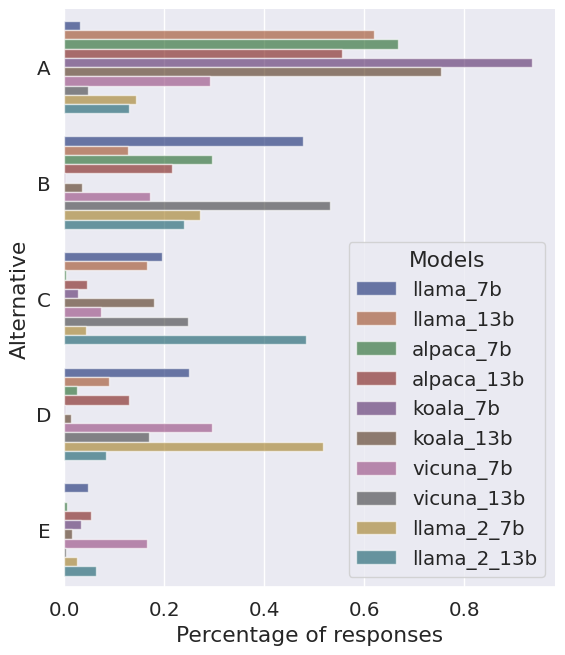

In [23]:
sns.set_theme()
sns.set(font_scale=1.3)
g = sns.catplot(data = percents, kind = "bar", y = "alternative", x = 'percent', hue = 'model',
    errorbar="sd", palette="dark", alpha=.6, height=6)
g.despine(left=True)
g.set_axis_labels("Percentage of responses","Alternative")
g.legend.set_title("")
g.fig.set_figwidth(8)
g.fig.set_figheight(7)
g._legend.remove()
plt.legend(loc='lower right',title="Models")
plt.savefig("plots/distribution-alternatives-english.svg",format="svg")